# EHR A3
## GROUP: B
## MEMBERS: ERNEST CEBALLOS, JÚLIA GALIMANY, ORIOL GALIMANY


In [11]:
library(dplyr)
library(tidyr)
library(tibble)
library(lubridate)
library(readr)
library(stringr)
library(ggplot2)
library(data.table)
library(odbc)
library(RMariaDB)
library(DBI)

In [2]:
con <- dbConnect(
  drv = RMariaDB::MariaDB(),
  username = "ernest.ceballos",
  password = "EeWot5Bu",
  host = "ehr3.deim.urv.cat",
  dbname = "mimiciiiv14",
  port = 3306
)

# PART 1: COHORT 

### Cohort definition
We performed a retrospective observational study using the Medical Information Mart for Intensive Care III (MIMIC-III), version 1.4, a publicly available database containing de-identified health data from over 40,000 adult and neonatal ICU admissions at Beth Israel Deaconess Medical Center between 2001 and 2012 [1]. Our cohort comprised all adult patients aged 16 years or older with at least one ICU admission recorded in the ICUSTAYS table. Age was calculated as the difference in years between the ICU admission time (INTIME) and the patient’s date of birth. For patients with multiple ICU stays, each stay was considered an independent observation. Neonatal and pediatric admissions (age < 16 years) were excluded. The final analytical cohort included all qualifying ICU admissions available in the database, without further exclusion criteria.


In [3]:
cohort <- tbl(con, "ICUSTAYS") %>%
  # Unir amb admissions per obtenir hospital_expire_flag i admittime
  inner_join(tbl(con, "ADMISSIONS"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  # Unir amb patients per obtenir data de naixement i gènere
  inner_join(tbl(con, "PATIENTS"), by = c("SUBJECT_ID" = "SUBJECT_ID")) %>%
  # Calcular edat en anys
  mutate(
    age = year(INTIME) - year(DOB)
  ) %>%
  # Filtrar només adults (>=16 anys)
  filter(age >= 16) %>%
  # Seleccionar variables rellevants
  select(
    HADM_ID,
    SUBJECT_ID,
    ICUSTAY_ID,
    age,
    GENDER,
    INTIME,
    OUTTIME,
    HOSPITAL_EXPIRE_FLAG
  ) %>%
  distinct() %>%
  # Portar dades a memòria local
  collect()

# Renombrar columnes a minúscules per a facilitat
colnames(cohort) <- tolower(colnames(cohort))

# Verificació bàsica de la cohort
cat("Cohort created successfully.\n")
cat("Total ICU admissions:", nrow(cohort), "\n")
cat("Unique patients:", n_distinct(cohort$subject_id), "\n")
cat("Age range:", min(cohort$age, na.rm = TRUE), "-", max(cohort$age, na.rm = TRUE), "years\n")
cat("Female proportion:", round(mean(cohort$gender == "F") * 100, 1), "%\n")

# Guardar cohort per a ús pels companys (opcional però recomanat)
# Assegura't que la carpeta 'data/' existeix
dir.create("data", showWarnings = FALSE)
write.csv(cohort, "data/cohort.csv", row.names = FALSE)


Cohort created successfully.
Total ICU admissions: 53424 
Unique patients: 38598 
Age range: 16 - 311 years
Female proportion: 43.7 %


# PART 2: Sepsis prevalence

In [4]:
# Define sepsis using ICD-9-CM codes
sepsis_adm <- tbl(con, "DIAGNOSES_ICD") %>%
  filter(
    substr(ICD9_CODE, 1, 3) == "038" |
    ICD9_CODE %in% c("99591", "99592", "78552")
  ) %>%
  select(HADM_ID) %>%
  distinct() %>%
  collect()
# Standardize column names to lowercase for consistency
colnames(sepsis_adm) <- tolower(colnames(sepsis_adm))


In [5]:
cohort_sepsis <- cohort %>%
  mutate(
    sepsis = if_else(hadm_id %in% sepsis_adm$hadm_id, 1, 0)  # 1 = with sepsis, 0 = without sepsis
  )

In [6]:
# Calculate the total volume and proportion (prevalence) of sepsis cases within the ICU
sepsis_summary <- cohort_sepsis %>%
  summarise(
    total_icu_admissions = n(),
    sepsis_icu_admissions = sum(sepsis),
    sepsis_prevalence = sepsis_icu_admissions / total_icu_admissions
  )

sepsis_summary


total_icu_admissions,sepsis_icu_admissions,sepsis_prevalence
<int>,<dbl>,<dbl>
53424,7261,0.1359127


In [7]:
table(cohort_sepsis$sepsis)


    0     1 
46163  7261 

## PART 3: Sepsis Mortality 

First of all I will extract the HADM_ID with sepsis using the following ICD9_CODES ('99591','99592','78552') from the DIAGNOSES_ICD table, independently on which seq_num they are. Then for the others HADM_ID (that don't have the sepsis code) I will pick the ICD9_CODE present in seq_num = 1. I will create a column with sepsis present = 1, and sepsis no present = 0. At last I will do an inner join with the ICUSTAY table to obtain only the HADM_ID that were ingressed at the UCI, and last I will use the HOSPITAL_EXPIRE_FLAG from admissions to create a status (alive, deceased) column. 

In [8]:
sql <- "
WITH 
SEP_ADM AS (
SELECT HADM_ID, ICD9_CODE 
FROM DIAGNOSES_ICD
WHERE ICD9_CODE IN ('99591','99592','78552')
GROUP BY HADM_ID
),
NOSEP_ADM AS (
SELECT HADM_ID, ICD9_CODE
FROM DIAGNOSES_ICD
WHERE 
	SEQ_NUM = 1
	AND HADM_ID NOT IN (
		SELECT DISTINCT HADM_ID
    	FROM DIAGNOSES_ICD
    	WHERE ICD9_CODE IN ('99591', '99592', '78552'))
),
UN_SEP AS (
SELECT *
FROM SEP_ADM 
UNION ALL
SELECT *
FROM NOSEP_ADM
),
SEPS AS (
SELECT 
	u.HADM_ID,
	a.SUBJECT_ID,
	u.ICD9_CODE,
	dd.SHORT_TITLE,
	CASE 
		WHEN u.ICD9_CODE IN ('99591', '99592', '78552') THEN 1
		ELSE 0
	END AS SEPSIS,
	a.HOSPITAL_EXPIRE_FLAG 
FROM UN_SEP u
INNER JOIN D_ICD_DIAGNOSES dd ON u.ICD9_CODE = dd.ICD9_CODE
INNER JOIN ADMISSIONS a ON u.HADM_ID = a.HADM_ID
),
ICU_JOIN AS (
SELECT 
	s.HADM_ID, s.SUBJECT_ID, 
	MIN(i.ICUSTAY_ID) AS ICUSTAY_ID, #To only keep one of the ICUSTAYS if there are multiple per HADM_ID 
	s.ICD9_CODE, s.SHORT_TITLE, s.SEPSIS, 
	CASE 
		WHEN s.HOSPITAL_EXPIRE_FLAG = 1 THEN 'Deceased'
		ELSE 'Alive'
	END AS STATUS
FROM SEPS s
INNER JOIN ICUSTAYS i ON s.HADM_ID = i.HADM_ID
GROUP BY s.HADM_ID 
)
SELECT *
FROM ICU_JOIN
"
mortality_df <- dbGetQuery(con, sql) 

In [9]:
head(mortality_df)

,HADM_ID,SUBJECT_ID,ICUSTAY_ID,ICD9_CODE,SHORT_TITLE,SEPSIS,STATUS
,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>
1,100001,58526,275225,25013,DMI ketoacd uncontrold,0,Alive
2,100003,54610,209281,53100,Ac stomach ulcer w hem,0,Alive
3,100006,9895,291788,49320,Chronic obst asthma NOS,0,Alive
4,100007,23018,217937,56081,Intestinal adhes w obstr,0,Alive
5,100009,533,253656,41401,Crnry athrscl natve vssl,0,Alive
6,100010,55853,271147,1890,Malig neopl kidney,0,Alive


In [ ]:
#Mortality tables for Sepsis and No sepsis
#I will use the deaths in percentage from the total of the group

STATUS,count,Percentage_Status
<chr>,<int>,<dbl>
Alive,3659,68.7782
Deceased,1661,31.2218


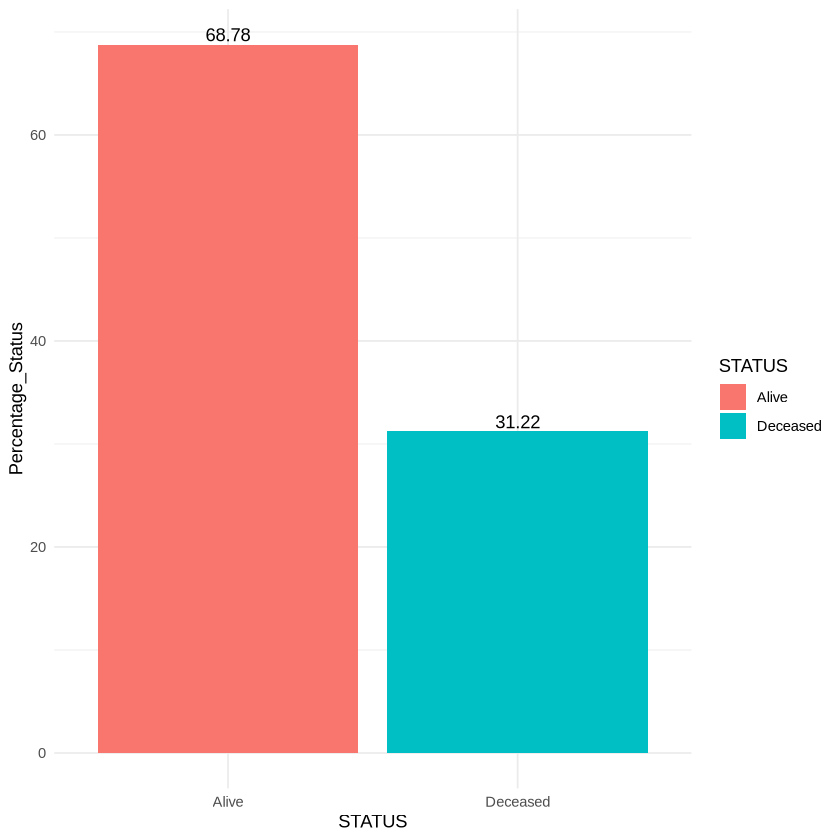

In [13]:
#With sepsis:
df2 <- mortality_df %>%
  filter(SEPSIS == 1) %>%
  group_by(STATUS)%>%
  summarise(count = n())%>%
  mutate(Percentage_Status = count / sum(count) * 100)

head(df2)

ggplot(df2,
       aes(x=STATUS, 
           y=Percentage_Status, 
           fill = STATUS, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  theme_minimal()

STATUS,count,Percentage_Status
<chr>,<int>,<dbl>
Alive,47692,92.094388
Deceased,4094,7.905612


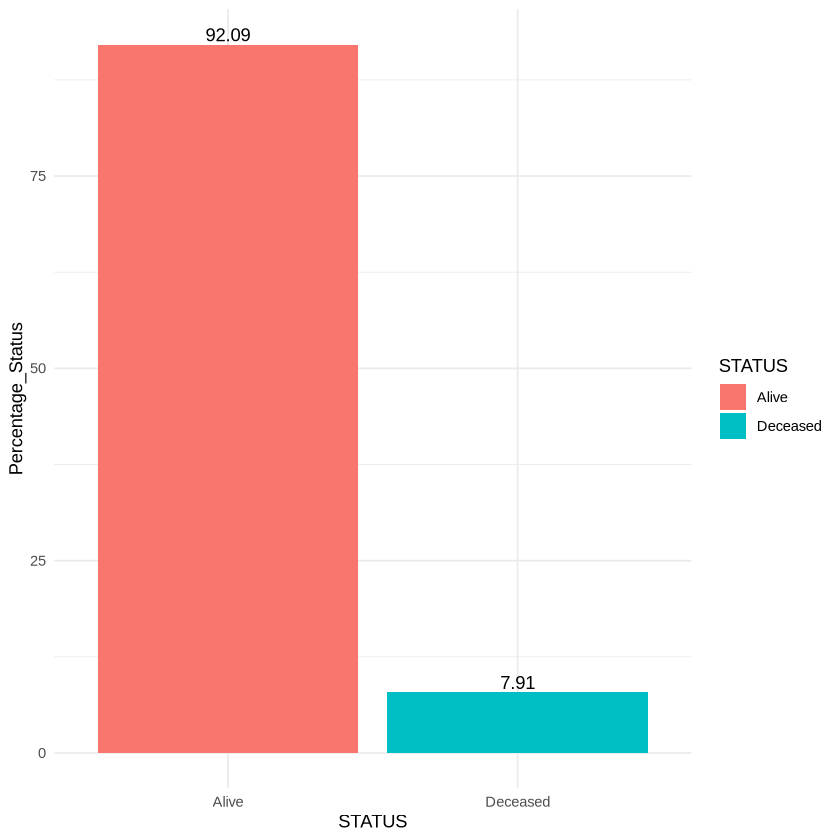

In [14]:
#Without Sepsis
df2 <- mortality_df %>%
  filter(SEPSIS == 0) %>%
  group_by(STATUS)%>%
  summarise(count = n())%>%
  mutate(Percentage_Status = count / sum(count) * 100)

head(df2)

ggplot(df2,
       aes(x=STATUS, 
           y=Percentage_Status, 
           fill = STATUS, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  theme_minimal()